# An example of how to generate GradCAM output maps for given images
Download the finetuned model checkpoint `checkpoint-finetuned.zip` from [here](https://zenodo.org/records/13677353) and extract the checkpoint files.

Prepare your data as a numpy array. The model will accept a batch of images of shape (N, 224, 224, 1), where N is the number of images in the batch, and the images are clipped and arcsinh stretched. Below, my images are in a HDF5 file, but you can update this as necessary for different data.

In [1]:
import h5py
import numpy as np 
import skimage

In [2]:
cutouts = h5py.File('example_data.hdf')
images = []

for key in cutouts.keys():
    cutout = np.array(cutouts[key]['DATA'])
    mask = np.array(cutouts[key]['MASK']).astype(int) & (1 | (1 << 8) | (1 << 9))

    # Resize to (224, 224)
    mask = skimage.transform.resize(mask, (224,224))
    img = skimage.transform.resize(cutout, (224,224))

    # Scale images and apply the mask
    img = np.clip(img, a_min=0, a_max=10)
    img = np.arcsinh(img / 0.017359)
    img = img * ~(mask > 0)

    # Place into array
    img = np.expand_dims(img, -1) # Reshape the array to (224, 224, 1)
    images.append(img)

data = np.array(images)

Create the model and load the finetuned weights. By default this function will look for the checkpoint data in the `./checkpoints/` folder. 

In [3]:
import sys
sys.path.append('..') # Hacky way to be able to import files from parent directory

from model import load_model

2024-12-11 14:58:04.049492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = load_model(model_name='checkpoint-finetuned', model_path_prefix='../checkpoints/')

We use functions from `gradcam.py` to create the GradCAM heatmaps. First, we split the original model in two. `last_conv_layer_model` maps input images to the activations in the last convolutional layer, which is the last layer to retain spatial information and therefore how we generate the heat maps. `grad_model` takes the output of `last_conv_layer_model` and takes it the rest of the way to the actual output of the model (the ICL fraction). `last_conv_layer_model` does not include the augmenter, so we pass this to `grad_model` separately. Both `grad_model` and `last_conv_layer_model` get their weights from the checkpointed model `model`.

Then, we create the heatmaps. Briefly, this is done by assigning all channels an importance calculated from the intensity of the gradient in this channel for the output of the model for the input image. The gradients of all channels are summed, weighted by importance, and then normalised to get the heatmap.

This heatmap shows us which areas of the image cause the model to predict higher ICL fractions.

In [5]:
from gradcam import make_grad_model, make_gradcam_heatmap
from augmentations import val_augmenter

In [6]:
augmenter = val_augmenter((224,224,1))

last_conv_layer_model, grad_model = make_grad_model(model)
heatmaps, img_array = make_gradcam_heatmap(data, augmenter, last_conv_layer_model, grad_model)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2024-12-11 14:58:24.182584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2024-12-11 14:58:24.182745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2024-12-11 14:58:24.206688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2024-12-11 14:58:24.206952: I tens

We now have N heatmaps and N image arrays, which represent what the model actually sees once the input data goes through the augmenter (when using the validation augmenter, this should be basically indistinguishable from the input data, but if using the training augmenter, the images will be randomly flipped and rotated as well.)

In [7]:
print(heatmaps.shape, img_array.shape)

(5, 56, 56) (5, 224, 224)


The heatmaps are a different shape to the input arrays, because the final convolutional layer produces a 56 x 56 activation map due to the architecture of the encoder. To display these, we need to reshape them to the same size as the input image, and then superpose these heatmaps on top of the original images. 

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

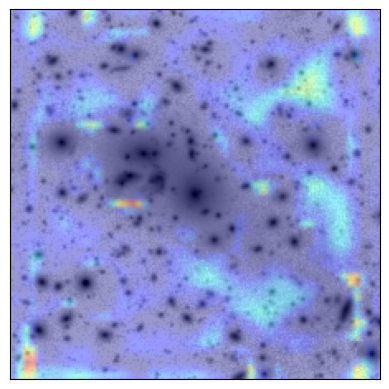

In [9]:
# Pick one of the heatmaps to view
idx = 0
image = img_array[idx]

# Normalise the image array
image = ((image - np.min(image)) / (np.max(image) - np.min(image))).squeeze()
# Get RGB values of the image when plotted with the 'gray_r' colormap
image = np.uint8(255 * image)
gray = mpl.colormaps['gray_r']
gray_colours = gray(np.arange(256))[:,:3] # discretise colormap and extract rgb ([:3]) values
image = gray_colours[image]

# Get RGB values of the heatmap when plotted with the 'jet' colormap
heatmap = np.uint8(255 * heatmaps[idx])
jet = mpl.colormaps.get_cmap('jet')
jet_colours = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colours[heatmap]

# Resize the heatmap to the same size as the image
jet_heatmap = skimage.transform.resize(jet_heatmap, (image.shape[0], image.shape[1]))

# Superimpose on the original image
superimposed_img = jet_heatmap * 0.4 + image * 0.6
plt.imshow(superimposed_img.squeeze())
plt.xticks([])
plt.yticks([])
plt.show()